In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import time
import signal

In [2]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [3]:
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags

In [16]:
class Buffer:
    def __init__(self, nparray, ro=False, dual=False):
        self.ro = ro
        self.dual = dual
        self.host = nparray
        flags = 0
        if ro:
            flags |= mf.READ_ONLY
        else:
            flags |= mf.READ_WRITE
        mkbuf = lambda buf: cl.Buffer(ctx, flags | mf.COPY_HOST_PTR, hostbuf=buf)
        self.buf = mkbuf(self.host)
        if dual:
            self.dbuf = mkbuf(self.host)
    
    def swap(self):
        if self.dual:
            self.buf, self.dbuf = self.dbuf, self.buf
    
    def load(self):
        cl.enqueue_copy(queue, self.host, self.buf)

In [24]:
program = cl.Program(ctx, """

#define TRACE_FADE      0.001
#define TRACE_DIFFUSION 0.1

uint rand_int(__global uint *seed) {
    return (*seed = 1103515245**seed + 12345);
}


float rand_uniform(__global uint *seed) {
    return (float)rand_int(seed)/(float)0xffffffff;
}


bool is_inside(int2 p, int2 l, int2 h) {
    return l.x <= p.x && p.x < h.x && l.y <= p.y && p.y < h.y;
}

int2 idir(int idx) {
    return (int2)(((idx+1)%2)*(1-idx), (idx%2)*(2-idx));
}

int fpos(int2 pos, int2 size) {
    return pos.x + size.x*pos.y;
}

__kernel void w_step(
    __global const float *w_trace_src,
    __global float *w_trace_dst
) {
    int2 gi = (int2)(get_global_id(0), get_global_id(1));
    int2 gs = (int2)(get_global_size(0), get_global_size(1));
    float v = w_trace_src[fpos(gi, gs)];
    
    // diffusion
    float dv = 0.0;
    int np[4];
    int i;
    for (i = 0; i < 4; ++i) {
        int2 ni = gi + idir(i);
        float nv;
        if (is_inside(ni, (int2)(0,0), gs)) {
            nv = w_trace_src[fpos(ni, gs)];
        } else {
            nv = v;
        }
        dv += TRACE_DIFFUSION*(nv - v);
    }
    v += dv;
    
    // fade
    v *= 1.0 - TRACE_FADE;
    
    w_trace_dst[fpos(gi, gs)] = v;
}


__kernel void a_step(
    __constant int *world_size,
    __constant int *agent_size,
    __global uint *a_random,

    __global int *a_agents,
    __global const float *w_trace_src,
    __global float *w_trace_dst
) {
    int gi = get_global_id(0);
    int gs = get_global_size(0);
    int2 ws = vload2(0, world_size);
    __global int *agent = a_agents + gi*agent_size[0];

    int2 pos = vload2(0, agent);
    int d = rand_int(&(a_random[gi])) % 5;
    pos += (d != 0)*(int2)((d%2)*(2-d), ((d+1)%2)*(3-d));
    pos = clamp(pos, (int2)(0, 0), ws - (int2)(1,1));
    vstore2(pos, 0, agent);

    uint p = (pos.x + ws.x*pos.y);
    w_trace_dst[p] = 1.0;
}


__kernel void w_draw(
    __global const float *w_trace,
    __global uchar *w_screen
) {
    int2 gi = (int2)(get_global_id(0), get_global_id(1));
    int2 gs = (int2)(get_global_size(0), get_global_size(1));
    int p = (gi.x + gs.x*gi.y);
    uchar c = (uchar)(255*w_trace[p]);
    uchar3 col = (uchar3)(c, c, 0);
    vstore3(col, p, w_screen);
}


__kernel void a_draw(
     __constant int *world_size,
     __constant int *agent_size,

    __global const int *a_agents,
    __global uchar *w_screen
) {
    int gi = get_global_id(0);
    int gs = get_global_size(0);
    int2 ws = vload2(0, world_size);
    const __global int *agent = a_agents + gi*agent_size[0];

    int2 pos = vload2(0, agent);
    int p = (pos.x + ws.x*pos.y);
    uchar c = 255;
    uchar3 col = (uchar3)(c, c, c);
    vstore3(col, p, w_screen);
}

""").build()

In [25]:
class World:
    def __init__(self, size, n_agents):
        self.size = size
        self.w_shape = (size[1], size[0])
        self.n_agents = (n_agents,)
        self.a_shape = (n_agents,)
        
        self.buffers = {}
        
        self.buffers["world_size"] = Buffer(np.array(self.size, dtype=np.int32), ro=True)
        
        self.buffers["w_screen"] = Buffer(np.zeros((*self.w_shape, 3), dtype=np.uint8))
        
        self.buffers["a_random"] = Buffer(np.random.randint(1<<32, size=self.a_shape, dtype=np.uint32))
        self.buffers["w_random"] = Buffer(np.random.randint(1<<32, size=self.w_shape, dtype=np.uint32))
        
        self.buffers["w_tracks"] = Buffer(np.zeros(self.w_shape, dtype=np.float32), dual=True)
        
        a_x = np.random.randint(0, self.size[0], size=self.a_shape)
        a_y = np.random.randint(0, self.size[1], size=self.a_shape)
        a_score = np.zeros(self.a_shape)
        self.buffers["a_agents"] = Buffer(np.stack((a_x, a_y, a_score), axis=1).astype(np.int32))
        self.buffers["agent_size"] = Buffer(np.array([self.buffers["a_agents"].host.shape[-1]], dtype=np.int32), ro=True)
        
    def step(self):
        program.w_step(
            queue,
            self.size,
            None,
            
            self.buffers["w_tracks"].buf,
            self.buffers["w_tracks"].dbuf,
        )
        program.a_step(
            queue,
            self.n_agents,
            None,
            
            self.buffers["world_size"].buf,
            self.buffers["agent_size"].buf,
            self.buffers["a_random"].buf,
            
            self.buffers["a_agents"].buf,
            self.buffers["w_tracks"].buf,
            self.buffers["w_tracks"].dbuf,
        )
        for buf in self.buffers.values():
            if buf.dual:
                buf.swap()
        
    def draw(self):
        program.w_draw(
            queue,
            self.size,
            None,
            
            self.buffers["w_tracks"].buf,
            self.buffers["w_screen"].buf,
        )
        program.a_draw(
            queue,
            self.n_agents,
            None,
            
            self.buffers["world_size"].buf,
            self.buffers["agent_size"].buf,
            
            self.buffers["a_agents"].buf,
            self.buffers["w_screen"].buf,
        )
        self.buffers["w_screen"].load()
        return self.buffers["w_screen"].host

In [26]:
world = World((800, 600), 256)

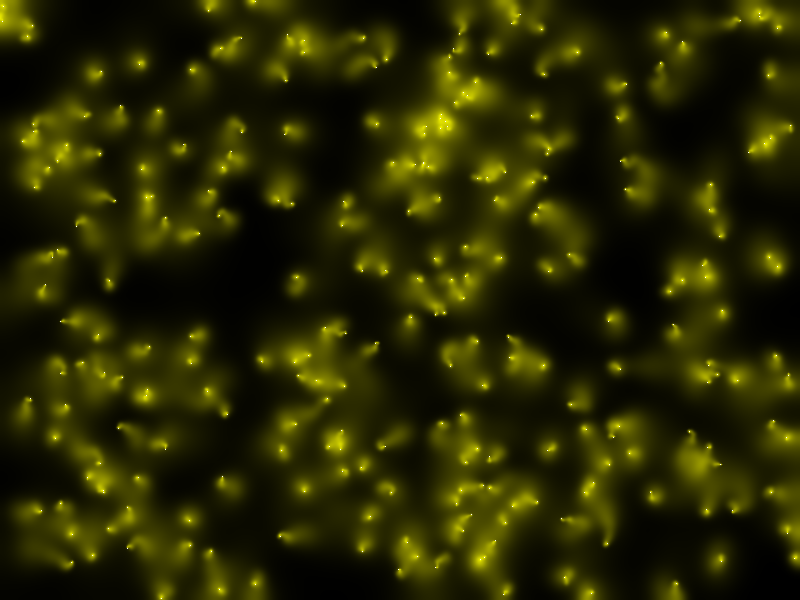

steps elapsed: 8162


In [27]:
stop_on_signal()
last = time.time()
n_steps = 0
while not signal_done:
    world.step()
    n_steps += 1
    now = time.time()
    if now - last >= 2.0:
        clear_output(wait=True)
        display(Image.fromarray(world.draw()))
        print("steps elapsed: %s" % n_steps)
        last = now

In [28]:
from skvideo.io import FFmpegWriter
from IPython.display import HTML
import base64
import io

In [29]:
params = {
    "-vcodec": "libx264",
    "-pix_fmt": "yuv420p",
    "-profile:v": "baseline",
    "-level": "3"
}
video = FFmpegWriter("tmp.mp4", outputdict=params)
stride = 10
for i in range(10*24):
    for j in range(stride):
        world.step()
    img = world.draw()
    video.writeFrame(img)
video.close()

In [ ]:
with open("tmp.mp4", "rb") as f:
    vdata = f.read()
vbase64 = base64.b64encode(vdata).decode("ascii")
HTML('<video controls src="data:video/mp4;base64,%s" type="video/mp4" >' % vbase64)